<a href="https://colab.research.google.com/github/ikoghoemmanuell/Bizstech-Msc.-Cybersecurity-/blob/main/Copy_of_model_2_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

Find below a simple example, with just 10 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

# Installation

In [1]:
# !pip install zipfile

!pip install transformers
!pip install datasets
!pip install --upgrade accelerate
!pip install sentencepiece

## Importing Libraries

In [2]:
import huggingface_hub # Importing the huggingface_hub library for model sharing and versioning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import os

from datasets import DatasetDict, Dataset
from sklearn.metrics import mean_squared_error, classification_report

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from google.colab import drive
import zipfile
import torch

## Load Dataset and Delete Null Values

In [3]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/fake news/archive (2).zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV files in the zip folder
    fake_path = zip_ref.extract('Fake.csv', '/content/')
    real_path = zip_ref.extract('True.csv', '/content/')

# Read the csv file from the url
fake = pd.read_csv(fake_path)
real = pd.read_csv(real_path)

# A way to delete rows with empty or null values
fake = fake[~fake.isna().any(axis=1)]
real = real[~real.isna().any(axis=1)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
fake["label"] = 1
real["label"] = 0

In [5]:
df = pd.concat([fake, real], axis =0 )
df.head(10)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",1
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",1
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",1
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",1


## Splitting the dataset

In [6]:
# Split the train data => {train, eval}  train 80%, test 20%
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [7]:
# get the first 5 rows of the train set to make sure it looks right
train.head()

,title,text,subject,date,label
13447,France invites U.S. to Dec. 13 summit on boost...,ACCRA (Reuters) - French President Emmanuel Ma...,worldnews,"November 30, 2017",0
7067,Trump keeps politics on his Thanksgiving menu,"WEST PALM BEACH, Fla./WASHINGTON (Reuters) - U...",politicsNews,"November 24, 2016",0
13988,Ireland's Fianna Fail party says will be elect...,DUBLIN (Reuters) - Ireland s second-largest pa...,worldnews,"November 24, 2017",0
9447,REPUBLICAN LEADER Implies He May Not Seat Roy ...,The New York Times just confirmed what we ve a...,politics,"Nov 12, 2017",1
1399,U.S. Senate approves Trump pick as top Fed reg...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"October 5, 2017",0


In [8]:
# check datatypes of the train set, object can mean text or string
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35918 entries, 13447 to 1255
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    35918 non-null  object
 1   text     35918 non-null  object
 2   subject  35918 non-null  object
 3   date     35918 non-null  object
 4   label    35918 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [9]:
# get the first 5 rows of the eval or test set
eval.head()

,title,text,subject,date,label
2349,Dem AGs Respond To Trump Rolling Back Clean W...,Amateur president Donald Trump s hostility tow...,News,"March 1, 2017",1
4958,Trump to nominate Goldman Sachs' Donovan as de...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"March 15, 2017",0
17343,Iraqi forces to regain Kurdish oilfields to re...,BAGHDAD (Reuters) - Iraq will deploy troops to...,worldnews,"October 16, 2017",0
15166,Britain agrees to set EU 'Exit Day' in law,LONDON (Reuters) - Britain s government said o...,worldnews,"November 9, 2017",0
36,Republican National Committee: Better A Pedop...,"By now, the whole world knows that Alabama Sen...",News,"December 5, 2017",1


In [10]:
eval.label.unique()

array([1, 0])

In [11]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (35918, 5), eval is (8980, 5)


([<matplotlib.patches.Wedge at 0x7f39478c9cc0>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

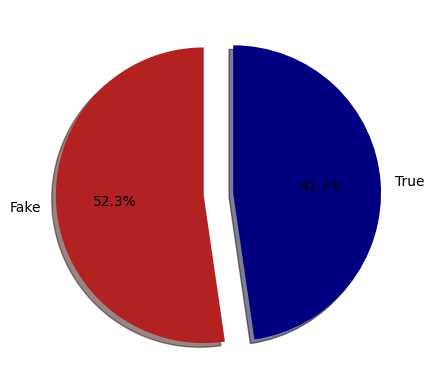

In [12]:
# 90 true, 10 fake, 70, 30
# 40, 60 good, 55, 45 is good
# Checking if our df is well balanced
label_size = [df['label'].sum(),len(df['label'])-df['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Creating a pytorch dataset

In [43]:
# transformers library allows you to use pytorch or tensorflow to save your dataset
# pytorch dataset looks like a dictoinary
# using this rep works well with the transformers library

# Create a pytorch dataset to ensure consistency in our data handling

# Create a train and eval datasets using the specified columns from the DataFrame
train_dataset = Dataset.from_pandas(train[['text', 'title', 'label']])
eval_dataset = Dataset.from_pandas(eval[['text', 'title', 'label']])

# Combine the train and eval datasets into a DatasetDict
dataset = DatasetDict({'train': train_dataset, 'eval': eval_dataset})

# Remove the '__index_level_0__' column from the dataset
dataset = dataset.remove_columns('__index_level_0__')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'title', 'label'],
        num_rows: 35918
    })
    eval: Dataset({
        features: ['text', 'title', 'label'],
        num_rows: 8980
    })
})

## Preprocessing and tokenization

In [44]:
# define helper functions

# funtion to replace usernames and links with placeholders.
def preprocess(text):
  # "@user my name is john"
  # "http my name is john"
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# no need for encoding: Fake=1, True=0 bcuz the target variable called label is already encoded

In [45]:
# Define the apply_preprocess function
def apply_preprocess(dataset, column='title'):
    return dataset.map(lambda example: {column: preprocess(example[column])},
                       remove_columns=[column])

# Apply the preprocess function to the 'title' column in both 'train' and 'eval' datasets
dataset['train'] = apply_preprocess(dataset['train'])
dataset['eval'] = apply_preprocess(dataset['eval'])

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

###Tokenization

Text(0, 0.5, 'Number of texts')

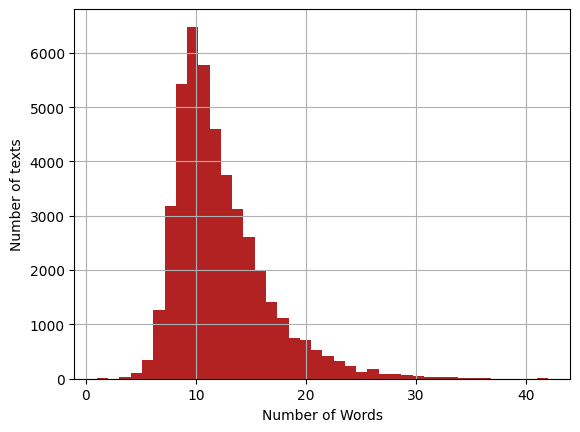

In [46]:
# Plot histogram of the number of words in train data 'text'
seq_len = [len(text.split()) for text in df['title']]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [47]:
# define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("elozano/bert-base-cased-fake-news")

def tokenize_data(example):
    return tokenizer(example['title'], padding='max_length', # compress all sentences to maximum of 30 words which is the max_length
                     truncation=True, # cut the sentenced to 30_words
                     max_length=20 # increasing the max length doesn't guarantee a better score
                     )

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns or columns that are not tokenized
remove_columns = ['text', 'title']
dataset = dataset.map(remove_columns=remove_columns)
dataset

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35918
    })
    eval: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8980
    })
})

## Trianing

In [48]:
# Loading a pretrain model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("elozano/bert-base-cased-fake-news")

In [49]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments("test_trainer",
                                  num_train_epochs=2, # epoch is ow many times you repeat training
                                  load_best_model_at_end=True,
                                  save_strategy='epoch',
                                  evaluation_strategy='epoch',
                                  logging_strategy='epoch',
                                  per_device_train_batch_size=32, # smaller batches take longer to train
                                  )

In [50]:
# set up the optimizer with the PyTorch implementation of AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) # I specified the optimizer to avoid a warning message

In [51]:
train_dataset = dataset['train'].shuffle(seed=24)
eval_dataset = dataset['eval'].shuffle(seed=24) # scatter the dataset 24 times randomly

In [52]:
def compute_metrics(eval_pred):      # specify the evaluation metric
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "rmse": mean_squared_error(labels, predictions, squared=False),
        "classification_report": classification_report(labels, predictions)
    }

In [53]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [54]:
trainer.train()  # rmse 0 to 1 closer to 0 means better performance.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rmse,Classification Report
1,0.112800,0.051050,0.115599,precision recall f1-score support 0 0.98 0.99 0.99 4284 1 0.99 0.98 0.99 4696 accuracy 0.99 8980 macro avg 0.99 0.99 0.99 8980 weighted avg 0.99 0.99 0.99 8980
2,0.024900,0.047632,0.109666,precision recall f1-score support 0 0.98 0.99 0.99 4284 1 0.99 0.98 0.99 4696 accuracy 0.99 8980 macro avg 0.99 0.99 0.99 8980 weighted avg 0.99 0.99 0.99 8980


Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Ten

TrainOutput(global_step=2246, training_loss=0.06883141151625241, metrics={'train_runtime': 383.6577, 'train_samples_per_second': 187.24, 'train_steps_per_second': 5.854, 'total_flos': 738314288001600.0, 'train_loss': 0.06883141151625241, 'epoch': 2.0})

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [55]:
# Launch the final evaluation
trainer.evaluate()  # eval loss is the performance cost of finetuning (0 to 1) 0.5 and above is not suitable.

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.04763183742761612,
 'eval_rmse': 0.10966643086152872,
 'eval_classification_report': '              precision    recall  f1-score   support\n\n           0       0.98      0.99      0.99      4284\n           1       0.99      0.98      0.99      4696\n\n    accuracy                           0.99      8980\n   macro avg       0.99      0.99      0.99      8980\nweighted avg       0.99      0.99      0.99      8980\n',
 'eval_runtime': 17.1893,
 'eval_samples_per_second': 522.417,
 'eval_steps_per_second': 65.331,
 'epoch': 2.0}

## Pushing to HuggingFace
Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

In [56]:
huggingface_hub.notebook_login()
# login to the Hugging Face Hub with your token

In [57]:
# # Push model and tokenizer to HugginFace
model.push_to_hub("ikoghoemmanuell/finetuned_fake_news_bert") # (username/model_name)
tokenizer.push_to_hub("ikoghoemmanuell/finetuned_fake_news_bert")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:803 in push_to_hub             │
│                                                                                                  │
│    800 │   │   else:                                                                             │
│    801 │   │   │   working_dir = repo_id.split("/")[-1]                                          │
│    802 │   │                                                                                     │
│ ❱  803 │   │   repo_id = self._create_repo(                                                      │
│    804 │   │   │   repo_id, private=private, use_auth_token=use_auth_token, repo_url=repo_url,   │
│    805 │   │   )                                                                                 │
│    806                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:661 in _create_repo            │
│                                                                                                  │
│    658 │   │   │   │   │   repo_id = repo_id.split("/")[-1]                                      │
│    659 │   │   │   │   repo_id = f"{organization}/{repo_id}"                                     │
│    660 │   │                                                                                     │
│ ❱  661 │   │   url = create_repo(repo_id=repo_id, token=use_auth_token, private=private, exist_  │
│    662 │   │                                                                                     │
│    663 │   │   # If the namespace is not there, add it or `upload_file` will complain            │
│    664 │   │   if "/" not in repo_id and url != f"{HUGGINGFACE_CO_RESOLVE_ENDPOINT}/{repo_id}":  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:118 in _inner_fn    │
│                                                                                                  │
│   115 │   │   if check_use_auth_token:                                                           │
│   116 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   117 │   │                                                                                      │
│ ❱ 118 │   │   return fn(*args, **kwargs)                                                         │
│   119 │                                                                                          │
│   120 │   return _inner_fn  # type: ignore                                                       │
│   121                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/hf_api.py:2304 in create_repo            │
│                                                                                                  │
│   2301 │   │   │   # Testing purposes only.                                                      │
│   2302 │   │   │   # See https://github.com/huggingface/huggingface_hub/pull/733/files#r8206044  │
│   2303 │   │   │   json["lfsmultipartthresh"] = self._lfsmultipartthresh  # type: ignore         │
│ ❱ 2304 │   │   headers = self._build_hf_headers(token=token, is_write_action=True)               │
│   2305 │   │   r = get_session().post(path, headers=headers